## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
#!pip install wordcloud

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = '/Users/I500955/Documents/PG/Semantic Processing/complaints-2021-05-14_08_16.json'
  
# returns JSON object as a dictionary 
with open(f) as json_file:
    data = json.load(json_file)

# Normalize JSON data and convert it into a DataFrame
df = pd.json_normalize(data)

print(df.head())

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
print(df.shape)
print(df.info())

(78313, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 n

In [5]:
# Analyzing the distribution of complaints across different issues to identify 
# the most common issues reported by consumers
print(df['_source.issue'].value_counts())

Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Unable to get credit report/credit score                                              1
Advertising, marketing or disclosures                                                 1
Problem with an overdraft                                                             1
Can't stop withdrawals from your bank account                                         1
Money was taken from your bank account on the wrong day or for the wrong amount       1
Name: _source.issue, Length: 154

In [6]:
product_counts = df['_source.product'].value_counts()
print(product_counts)

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

In [7]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [8]:
#Assign new column names
df = df.rename(columns=lambda x: x.replace('_source.', ''))
df = df.rename(columns={'complaint_what_happened': 'complaint'})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _index                     78313 non-null  object 
 1   _type                      78313 non-null  object 
 2   _id                        78313 non-null  object 
 3   _score                     78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [9]:
#Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].replace('', np.nan)
print(df.head())

                _index      _type      _id  _score           tags zip_code  \
0  complaint-public-v2  complaint  3211475     0.0           None    90301   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember    319XX   
2  complaint-public-v2  complaint  3199379     0.0           None    77069   
3  complaint-public-v2  complaint  2673060     0.0           None    48066   
4  complaint-public-v2  complaint  3203545     0.0           None    10473   

  complaint_id                               issue              date_received  \
0      3211475   Attempts to collect debt not owed  2019-04-13T12:00:00-05:00   
1      3229299     Written notification about debt  2019-05-01T12:00:00-05:00   
2      3199379  Other features, terms, or problems  2019-04-02T12:00:00-05:00   
3      2673060      Trouble during payment process  2017-09-13T12:00:00-05:00   
4      3203545                    Fees or interest  2019-04-05T12:00:00-05:00   

  state  ...         company_response       

In [10]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'])

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Clean the text and remove all the unnecessary elements.
def preprocess_text(text):
    text=text.lower()  #convert to lower case
    text=re.sub(r'\[.*?\]', '',text) #Remove text in square brackets
    text=text.translate(str.maketrans('', '', string.punctuation)) #Remove punctuation
    text=re.sub(r'\w*\d\w*', '', text) #Remove words with numbers
    
    return text

df['complaint'] = df['complaint'].apply(preprocess_text)

print(df.head())

                 _index      _type      _id  _score           tags zip_code  \
1   complaint-public-v2  complaint  3229299     0.0  Servicemember    319XX   
2   complaint-public-v2  complaint  3199379     0.0           None    77069   
10  complaint-public-v2  complaint  3233499     0.0           None    104XX   
11  complaint-public-v2  complaint  3180294     0.0           None    750XX   
14  complaint-public-v2  complaint  3224980     0.0           None    920XX   

   complaint_id                                 issue  \
1       3229299       Written notification about debt   
2       3199379    Other features, terms, or problems   
10      3233499  Incorrect information on your report   
11      3180294  Incorrect information on your report   
14      3224980                   Managing an account   

                date_received state  ...         company_response  \
1   2019-05-01T12:00:00-05:00    GA  ...  Closed with explanation   
2   2019-04-02T12:00:00-05:00    TX  ...  Cl

In [12]:
#Write your function to Lemmatize the texts
nlp = spacy.load("en_core_web_sm")

def lemmatize_and_extract_nouns(text):
    doc = nlp(text)
    
    # Lemmatize tokens and extract only nouns
    lemmatized_nouns = []
    for token in doc:
        # Lemmatize token
        lemma = token.lemma_
        
        # Extract only nouns (NN)
        if token.pos_ == 'NOUN':
            lemmatized_nouns.append(lemma)
    
    # Join lemmatized nouns into a string
    lemmatized_text = ' '.join(lemmatized_nouns)
    
    return lemmatized_text

df['lemmatized_complaint'] = df['complaint'].apply(lemmatize_and_extract_nouns)

In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint', 'lemmatized_complaint']].copy()

print(df_clean.head())

                                            complaint  \
1   good morning my name is xxxx xxxx and i apprec...   
2   i upgraded my xxxx xxxx card in  and was told ...   
10  chase card was reported on  however fraudulent...   
11  on  while trying to book a xxxx  xxxx  ticket ...   
14  my grand son give me check for  i deposit it i...   

                                 lemmatized_complaint  
1   morning name stop bank cardmember service debt...  
2   xxxx card agent anniversary date agent informa...  
10  card application identity consent service cred...  
11  xxxx ticket offer ticket reward card informati...  
14  son check chase account fund chase bank accoun...  


In [14]:
#Extract the POS tags 

def pos_tag(text):
    doc = nlp(text)
    
    # Lemmatize tokens and extract only nouns
    lemmatized_nouns = []
    for token in doc:
        lemma = token.lemma_
        
        if token.pos_ == 'NOUN':
            lemmatized_nouns.append(lemma)
    
    # Join lemmatized nouns into a string
    lemmatized_text = ' '.join(lemmatized_nouns)
    
    return lemmatized_text

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaint"].apply(pos_tag)

print(df_clean.head())

                                            complaint  \
1   good morning my name is xxxx xxxx and i apprec...   
2   i upgraded my xxxx xxxx card in  and was told ...   
10  chase card was reported on  however fraudulent...   
11  on  while trying to book a xxxx  xxxx  ticket ...   
14  my grand son give me check for  i deposit it i...   

                                 lemmatized_complaint  \
1   morning name stop bank cardmember service debt...   
2   xxxx card agent anniversary date agent informa...   
10  card application identity consent service cred...   
11  xxxx ticket offer ticket reward card informati...   
14  son check chase account fund chase bank accoun...   

                                complaint_POS_removed  
1   morning name stop bank cardmember service debt...  
2   card agent anniversary date agent information ...  
10  card application identity consent service cred...  
11  xxxx ticket ticket reward card information min...  
14  account fund bank account mone

In [15]:
#clean dataframe with raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx risk consumer chase year banking merchant...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit chase credit card chase freedom balance...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0.5, 0, 'Complaint character length')

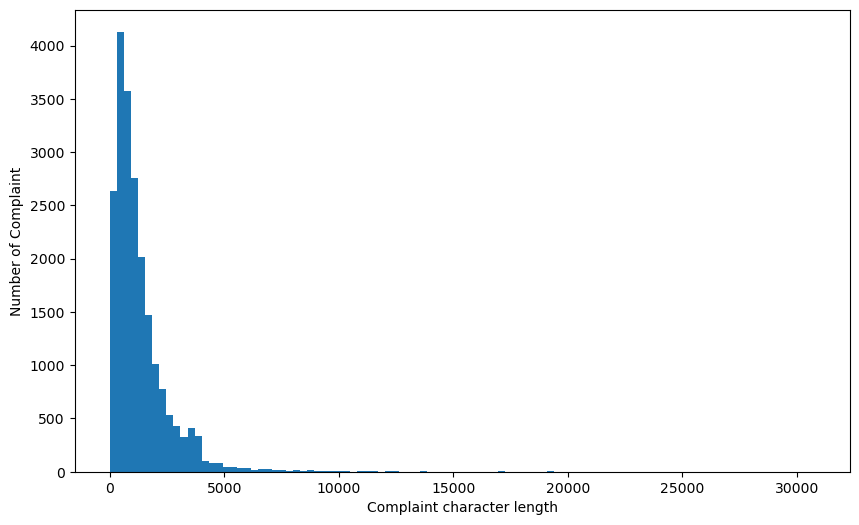

In [16]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')


#### Find the top 40 words by frequency among all the articles after processing the text.

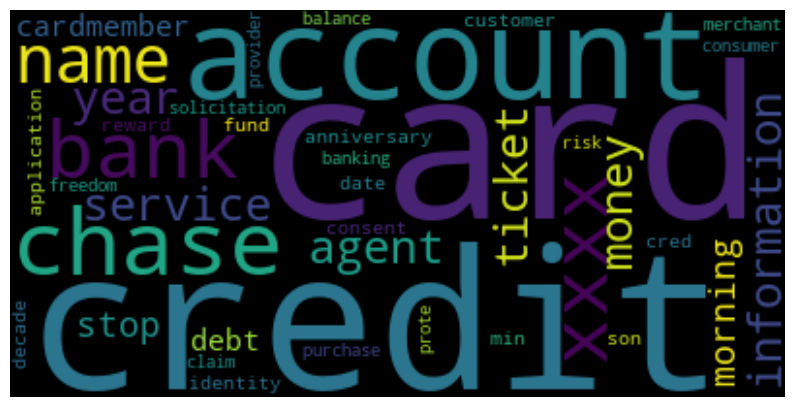

In [17]:
#Word cloud to find the top 40 words by frequency among all the articles after processing the text
from wordcloud import STOPWORDS

wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the 'complaint_POS_removed' column
X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

# Get feature names (unigrams)
feature_names = vectorizer.get_feature_names_out()

# Sum the occurrences of each unigram
unigram_freq = X.toarray().sum(axis=0)

# Combine feature names and frequencies
unigram_freq_dict = dict(zip(feature_names, unigram_freq))

# Sort the unigram frequencies in descending order
sorted_unigram_freq = sorted(unigram_freq_dict.items(), key=lambda x: x[1], reverse=True)

print("-------------Top 10 Unigrams----------")
for word, freq in sorted_unigram_freq[:10]:
    print(f'{word}: {freq}')

-------------Top 10 Unigrams----------
chase: 43190
account: 38866
credit: 32045
card: 29924
payment: 21083
time: 15835
bank: 13190
day: 12784
money: 11330
xxxx: 10845


In [20]:
# Initialize CountVectorizer to create bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit and transform the 'complaint_POS_removed' column
X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum the occurrences of each bigram
bigram_freq = X.toarray().sum(axis=0)

# Combine feature names and frequencies
bigram_freq_dict = dict(zip(feature_names, bigram_freq))

# Sort the bigram frequencies in descending order
sorted_bigram_freq = sorted(bigram_freq_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 30 bigrams by frequency
print("----------Top 10 Bigrams by Frequency-------")
for bigram, freq in sorted_bigram_freq[:10]:
    print(f'{bigram}: {freq}')

----------Top 10 Bigrams by Frequency-------
credit card: 12813
credit report: 3737
chase credit: 2979
customer service: 2973
account account: 2677
chase account: 2639
account chase: 2420
debit card: 1869
card chase: 1755
card account: 1730


In [21]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fit and transform the 'complaint_POS_removed' column
X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum the occurrences of each bigram
trigram_freq = X.toarray().sum(axis=0)

# Combine feature names and frequencies
trigram_freq_dict = dict(zip(feature_names, trigram_freq))

# Sort the bigram frequencies in descending order
sorted_trigram_freq = sorted(trigram_freq_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 30 trigrams by frequency
print("----------Top 10 Trigrams by Frequency-------")
for trigram, freq in sorted_trigram_freq[:10]:
    print(f'{trigram}: {freq}')

----------Top 10 Trigrams by Frequency-------
chase credit card: 1957
credit card account: 1019
credit card company: 1003
credit card chase: 818
credit card credit: 616
xxxx credit card: 553
inquiry credit report: 523
card credit card: 494
account credit card: 464
credit report credit: 405


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [22]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [23]:
#All masked texts has been removed
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,ticket ticket reward card information minute ...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,account fund bank account money son money bank...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx risk consumer chase year banking merchant...,risk consumer chase year banking merchant mer...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit chase credit card chase freedom balance...,credit chase credit card chase freedom balance...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [24]:
#Write your code here to initialise the TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [25]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("First 10 Feature Names:", feature_names[:10])

TF-IDF Matrix Shape: (21072, 4812)
First 10 Feature Names: ['aarp' 'abandonment' 'abatement' 'abbreviation' 'abide' 'ability'
 'absence' 'absurdity' 'abundance' 'abuse']


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [26]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [27]:
#Load your nmf_model with the n_components i.e 5
num_topics = [5, 10, 15, 20] #write the value you want to test out


def create_nmf_model(tfidf_matrix, num_topics=5, random_state=40):
    # Initialize NMF with the current number of clusters
    nmf_model = NMF(n_components=num_topics, random_state=random_state)
        
    # Fit the NMF model to the TF-IDF matrix
    nmf_transformed = nmf_model.fit_transform(tfidf_matrix)
        
    print(f"Number of Clusters: {num_topics}")
    print("Top 15 Words per Topic:")
    for i, topic in enumerate(nmf_model.components_):
        top_words = [feature_names[j] for j in topic.argsort()[:-16:-1]]
        print(f"Topic {i}: {top_words}")
    
    return nmf_model, nmf_transformed

best_nmf_model, best_nmf_transformed = create_nmf_model(tfidf_matrix)

Number of Clusters: 5
Top 15 Words per Topic:
Topic 0: ['account', 'money', 'check', 'bank', 'fund', 'chase', 'day', 'deposit', 'branch', 'fee', 'number', 'transaction', 'business', 'time', 'customer']
Topic 1: ['card', 'charge', 'credit', 'chase', 'purchase', 'dispute', 'service', 'fraud', 'time', 'balance', 'transaction', 'merchant', 'company', 'fee', 'customer']
Topic 2: ['payment', 'balance', 'month', 'fee', 'statement', 'day', 'time', 'date', 'chase', 'auto', 'credit', 'bank', 'mortgage', 'year', 'error']
Topic 3: ['credit', 'report', 'inquiry', 'score', 'account', 'debt', 'card', 'company', 'information', 'reporting', 'identity', 'application', 'limit', 'theft', 'file']
Topic 4: ['loan', 'mortgage', 'chase', 'home', 'modification', 'year', 'property', 'time', 'rate', 'document', 'letter', 'foreclosure', 'sale', 'information', 'process']


In [28]:
# Apply the best number to create word clusters

def generate_word_clusters(nmf_model, feature_names, num_words=15):
    word_clusters = {}
    for cluster_label, topic in enumerate(nmf_model.components_):
        top_word_indices = topic.argsort()[:-num_words-1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        word_clusters[cluster_label] = top_words
    return word_clusters

# generate word clusters using the best number of clusters as follows:
word_clusters = generate_word_clusters(best_nmf_model, feature_names)

# Print the word clusters for each topic
for cluster_label, words in word_clusters.items():
    print(f"Cluster {cluster_label}: {words}")

Cluster 0: ['account', 'money', 'check', 'bank', 'fund', 'chase', 'day', 'deposit', 'branch', 'fee', 'number', 'transaction', 'business', 'time', 'customer']
Cluster 1: ['card', 'charge', 'credit', 'chase', 'purchase', 'dispute', 'service', 'fraud', 'time', 'balance', 'transaction', 'merchant', 'company', 'fee', 'customer']
Cluster 2: ['payment', 'balance', 'month', 'fee', 'statement', 'day', 'time', 'date', 'chase', 'auto', 'credit', 'bank', 'mortgage', 'year', 'error']
Cluster 3: ['credit', 'report', 'inquiry', 'score', 'account', 'debt', 'card', 'company', 'information', 'reporting', 'identity', 'application', 'limit', 'theft', 'file']
Cluster 4: ['loan', 'mortgage', 'chase', 'home', 'modification', 'year', 'property', 'time', 'rate', 'document', 'letter', 'foreclosure', 'sale', 'information', 'process']


In [29]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

cluster_topics = {
    0: "Credit card / Prepaid card",
    1: "Bank account services",
    2: "Theft/Dispute reporting",
    3: "Mortgages/loans",
    4: "Others"
}

# Assign cluster labels to the complaints in your DataFrame
df_clean['cluster_label'] = np.argmax(best_nmf_transformed, axis=1)

In [30]:
df_clean.head(5)

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,cluster_label
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,4
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,card application identity consent service cred...,3
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,ticket ticket reward card information minute ...,3
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,account fund bank account money son money bank...,0


In [31]:
#Assign the best topic to each of the cmplaints in Topic Column

# Manual Observation based on cluster words and given topics
# Cluster O: Topic 1:  "Bank account services" 
# Cluster 1: Topic 2: "Theft/Dispute reporting"
# Cluster 2: Topic 4: "Others"
# Cluster 3: Topic 0: "Credit card / Prepaid card"
# Cluster 4: Topic 3: "Mortgages/loans"

# Best Mapping of cluster labels to topics based on manual observation
best_cluster_topics_mapping = {
    0: "Bank account services",
    1: "Theft/Dispute reporting",
    2: "Others",
    3: "Credit card / Prepaid card",
    4: "Mortgages/loans"
}

# write your code to assign topics to each rows.
df_clean['topic'] = df_clean['cluster_label'].map(best_cluster_topics_mapping)

print(df_clean.shape)

(21072, 6)


In [32]:
pd.set_option('display.max_colwidth', None)

df_clean[['Complaint_clean', 'cluster_label', 'topic']].head(5)

,Complaint_clean,cluster_label,topic
1,morning name stop bank cardmember service debt verification statement bank debt mail month debt information consumer chase help,4,Mortgages/loans
2,card agent anniversary date agent information order account anniversary date consent recording agent,1,Theft/Dispute reporting
10,card application identity consent service credit identity applicant,3,Credit card / Prepaid card
11,ticket ticket reward card information minute screen decision bank bank notification screen representative application information credit offer account statement ticket account application representative application request application chase fact credit account name credit report chase information credit report application error,3,Credit card / Prepaid card
14,account fund bank account money son money bank money son chase time check owner country time date check number claim number chase,0,Bank account services


In [37]:
print(df_clean.shape)

#Print the first 5 Complaint for each of the Topics
df_grouped = df_clean.groupby('topic').head(5)

# Iterate over each unique topic
for topic, group in df_grouped.groupby('topic'):
    print(f"Top 5 complaints for topic {topic}:")
    print('\n')
    for complaint in group['complaint']:
        print(complaint)
    print("=" * 50)

(21072, 6)
Top 5 complaints for topic Bank account services:


my grand son give me check for  i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase  times they told him i should call not him to verify the check owner he is out the country most the time  date happen  check number xxxx claim number is xxxx with chase
with out notice jp morgan chase restricted my account by my debit card tuesday  on thursday  i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but th

In [38]:
print(df_clean.shape)

(21072, 6)


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [39]:
#Create the dictionary of Topic names and Topics

Topic_Names = {
    "Bank account services": 0,
    "Theft/Dispute reporting": 1,
    "Others": 2 ,
    "Credit card / Prepaid card": 3,
    "Mortgages/loans": 4 
}
#Replace Topics with Topic Names
df_clean['topic'] = df_clean['topic'].map(lambda x: Topic_Names[x])

In [40]:
print(df_clean.shape)

(21072, 6)


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics - Not needed as we have already done it above

# Topic_names = {   }
#Replace Topics with Topic Names
# df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [41]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean.drop(['lemmatized_complaint', 'complaint_POS_removed', 'Complaint_clean', 'cluster_label'], axis=1)

In [42]:
training_data

,complaint,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me\n\nchase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for xxxx enrollment and failed to credit airline charge as agreed upon,1
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make a claim under their purchase protection benefit on xxxxxxxx i purchased three high school textbooks for my xxxx year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the chase representative assured me the textbooks wo

In [43]:
training_data.shape

(21072, 2)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [44]:
#Write your code to get the Vector count
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [45]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.topic, test_size=0.2, random_state=42)

In [47]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1153
           1       0.91      0.95      0.93      1251
           2       0.97      0.83      0.90       512
           3       0.93      0.86      0.89       553
           4       0.91      0.91      0.91       746

    accuracy                           0.92      4215
   macro avg       0.92      0.90      0.91      4215
weighted avg       0.92      0.92      0.92      4215



In [48]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1153
           1       0.81      0.83      0.82      1251
           2       0.76      0.73      0.75       512
           3       0.76      0.74      0.75       553
           4       0.82      0.79      0.80       746

    accuracy                           0.80      4215
   macro avg       0.79      0.78      0.79      4215
weighted avg       0.79      0.80      0.79      4215



In [49]:
# Random Forest Classifier
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78      1153
           1       0.54      0.94      0.69      1251
           2       0.96      0.05      0.10       512
           3       1.00      0.14      0.25       553
           4       0.86      0.64      0.73       746

    accuracy                           0.65      4215
   macro avg       0.82      0.53      0.51      4215
weighted avg       0.76      0.65      0.59      4215



In [50]:
df_complaints = pd.DataFrame({'complaints': ["Agent forced me to take insurance for my personal home loan", 
                                  "I got a scam call asking for my CVV.",
                                  "How to open a salary account. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "How many branches are there for the bank in Bengaluru."]})
df_complaints

,complaints
0,Agent forced me to take insurance for my personal home loan
1,I got a scam call asking for my CVV.
2,How to open a salary account. Please provide me the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,What is the procedure to know my CIBIL score?
5,How many branches are there for the bank in Bengaluru.


In [51]:
def predict_lr(text):
    Topic_names = { 
                    0: "Bank account services", 
                    1: "Theft/Dispute reporting", 
                    2: "Others", 
                    3: "Credit card / Prepaid card",
                    4: "Mortgages/loans"
                }
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [52]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,Agent forced me to take insurance for my personal home loan,Mortgages/loans
1,I got a scam call asking for my CVV.,Theft/Dispute reporting
2,How to open a salary account. Please provide me the procedure.,Bank account services
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute reporting
4,What is the procedure to know my CIBIL score?,Credit card / Prepaid card
5,How many branches are there for the bank in Bengaluru.,Bank account services
